In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from sklearn import preprocessing
from pandas.plotting import lag_plot
from pandas import Timestamp
from itertools import product
from tqdm.notebook import tqdm
import plotly.graph_objs as go
import plotly.express as px

import pmdarima as pm
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
sns.set_palette("icefire")
palette = sns.color_palette()

In [3]:
df = pd.read_csv("netflix_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [5]:
df

show_id     type                  title         director  \
0         s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show          Blood & Water              NaN   
2         s3  TV Show              Ganglands  Julien Leclercq   
3         s4  TV Show  Jailbirds New Orleans              NaN   
4         s5  TV Show           Kota Factory              NaN   
...      ...      ...                    ...              ...   
8802   s8803    Movie                 Zodiac    David Fincher   
8803   s8804  TV Show            Zombie Dumb              NaN   
8804   s8805    Movie             Zombieland  Ruben Fleischer   
8805   s8806    Movie                   Zoom     Peter Hewitt   
8806   s8807    Movie                 Zubaan      Mozez Singh   

                                                   cast        country  \
0                                                   NaN  United States   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2     Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                   NaN            NaN   
4     Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   
...                                                 ...            ...   
8802  Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...  United States   
8803                                                NaN            NaN   
8804  Jesse Eisenberg, Woody Harrelson, Emma Stone, ...  United States   
8805  Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...  United States   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   

              date_added  release_year rating   duration  \
0     September 25, 2021          2020  PG-13     90 min   
1     September 24, 2021          2021  TV-MA  2 Seasons   
2     September 24, 2021          2021  TV-MA   1 Season   
3     September 24, 2021          2021  TV-MA   1 Season   
4     September 24, 2021          2021  TV-MA  2 Seasons   
...                  ...           ...    ...        ...   
8802   November 20, 2019          2007      R    158 min   
8803        July 1, 2019          2018  TV-Y7  2 Seasons   
8804    November 1, 2019          2009      R     88 min   
8805    January 11, 2020          2006     PG     88 min   
8806       March 2, 2019          2015  TV-14    111 min   

                                              listed_in  \
0                                         Documentaries   
1       International TV Shows, TV Dramas, TV Mysteries   
2     Crime TV Shows, International TV Shows, TV Act...   
3                                Docuseries, Reality TV   
4     International TV Shows, Romantic TV Shows, TV ...   
...                                                 ...   
8802                     Cult Movies, Dramas, Thrillers   
8803             Kids' TV, Korean TV Shows, TV Comedies   
8804                            Comedies, Horror Movies   
8805                 Children & Family Movies, Comedies   
8806     Dramas, International Movies, Music & Musicals   

                                            description  
0     As her father nears the end of his life, filmm...  
1     After crossing paths at a party, a Cape Town t...  
2     To protect his family from a powerful drug lor...  
3     Feuds, flirtations and toilet talk go down amo...  
4     In a city of coaching centers known to train I...  
...                                                 ...  
8802  A political cartoonist, a crime reporter and a...  
8803  While living alone in a spooky town, a young g...  
8804  Looking to survive in a world taken over by zo...  
8805  Dragged from civilian life, a former superhero...  
8806  A scrappy but poor boy worms his way into a ty...  

[8807 rows x 12 columns]

In [6]:
# Strip leading and trailing whitespace from the 'date_added' column
df['date_added'] = df['date_added'].str.strip()

# Convert data_added from string to datetime
df['date_added'] = pd.to_datetime(df['date_added'], format="%B %d, %Y")

# Extract year and month
df['year_added'] = pd.DatetimeIndex(df['date_added']).year
df['month_added'] = df['date_added'].dt.month


In [7]:
df=df.dropna(subset=['year_added'])
df['year_added']=df['year_added'].astype(int)

In [8]:
df

show_id     type                  title         director  \
0         s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show          Blood & Water              NaN   
2         s3  TV Show              Ganglands  Julien Leclercq   
3         s4  TV Show  Jailbirds New Orleans              NaN   
4         s5  TV Show           Kota Factory              NaN   
...      ...      ...                    ...              ...   
8802   s8803    Movie                 Zodiac    David Fincher   
8803   s8804  TV Show            Zombie Dumb              NaN   
8804   s8805    Movie             Zombieland  Ruben Fleischer   
8805   s8806    Movie                   Zoom     Peter Hewitt   
8806   s8807    Movie                 Zubaan      Mozez Singh   

                                                   cast        country  \
0                                                   NaN  United States   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2     Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                   NaN            NaN   
4     Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   
...                                                 ...            ...   
8802  Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...  United States   
8803                                                NaN            NaN   
8804  Jesse Eisenberg, Woody Harrelson, Emma Stone, ...  United States   
8805  Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...  United States   
8806  Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...          India   

     date_added  release_year rating   duration  \
0    2021-09-25          2020  PG-13     90 min   
1    2021-09-24          2021  TV-MA  2 Seasons   
2    2021-09-24          2021  TV-MA   1 Season   
3    2021-09-24          2021  TV-MA   1 Season   
4    2021-09-24          2021  TV-MA  2 Seasons   
...         ...           ...    ...        ...   
8802 2019-11-20          2007      R    158 min   
8803 2019-07-01          2018  TV-Y7  2 Seasons   
8804 2019-11-01          2009      R     88 min   
8805 2020-01-11          2006     PG     88 min   
8806 2019-03-02          2015  TV-14    111 min   

                                              listed_in  \
0                                         Documentaries   
1       International TV Shows, TV Dramas, TV Mysteries   
2     Crime TV Shows, International TV Shows, TV Act...   
3                                Docuseries, Reality TV   
4     International TV Shows, Romantic TV Shows, TV ...   
...                                                 ...   
8802                     Cult Movies, Dramas, Thrillers   
8803             Kids' TV, Korean TV Shows, TV Comedies   
8804                            Comedies, Horror Movies   
8805                 Children & Family Movies, Comedies   
8806     Dramas, International Movies, Music & Musicals   

                                            description  year_added  \
0     As her father nears the end of his life, filmm...        2021   
1     After crossing paths at a party, a Cape Town t...        2021   
2     To protect his family from a powerful drug lor...        2021   
3     Feuds, flirtations and toilet talk go down amo...        2021   
4     In a city of coaching centers known to train I...        2021   
...                                                 ...         ...   
8802  A political cartoonist, a crime reporter and a...        2019   
8803  While living alone in a spooky town, a young g...        2019   
8804  Looking to survive in a world taken over by zo...        2019   
8805  Dragged from civilian life, a former superhero...        2020   
8806  A scrappy but poor boy worms his way into a ty...        2019   

      month_added  
0             9.0  
1             9.0  
2             9.0  
3             9.0  
4             9.0  
...           ...  
8802         11.0  


In [9]:
#Date_added should have no null values
df.isnull().sum()

show_id            0
type               0
title              0
director        2624
cast             825
country          830
date_added         0
release_year       0
rating             4
duration           3
listed_in          0
description        0
year_added         0
month_added        0
dtype: int64

<Axes: xlabel='type', ylabel='count'>

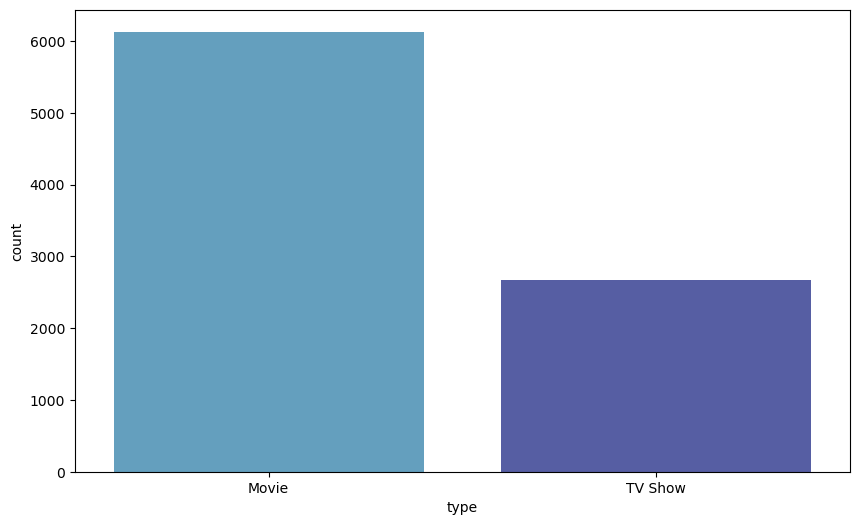

In [10]:
sns.countplot(x=df['type'])

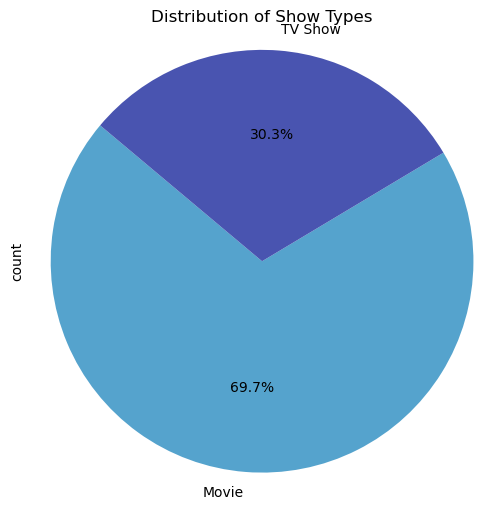

In [11]:
# Plot the pie chart
plt.figure(figsize=(6, 6))
df['type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Show Types')
plt.axis('equal')
plt.show()

In [12]:
type_counts = df['type'].value_counts()
print(type_counts)


type
Movie      6131
TV Show    2666
Name: count, dtype: int64


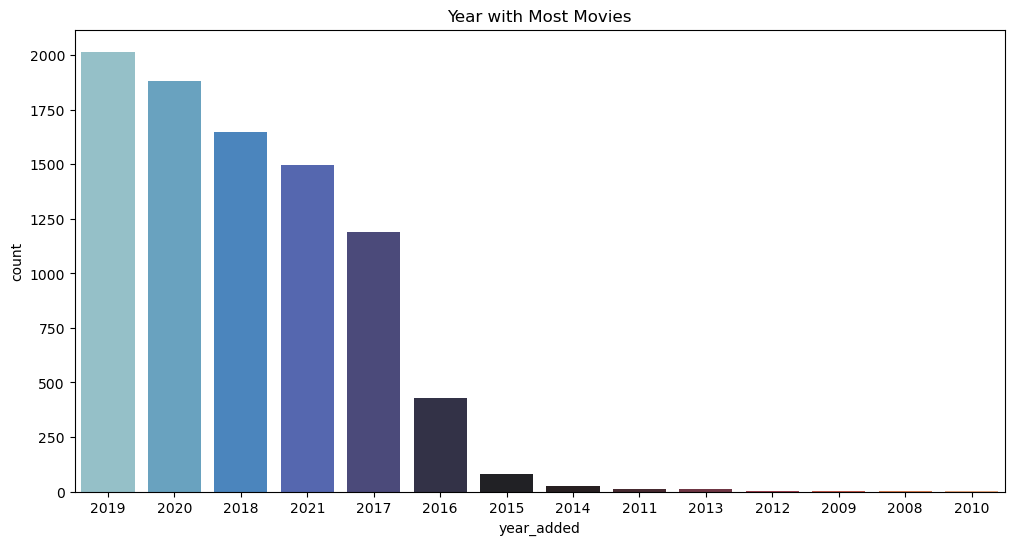

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x='year_added', data=df, order=df['year_added'].value_counts().index[:14], palette="icefire")
plt.title('Year with Most Movies')
plt.show()

Text(0, 0.5, 'Year Added')

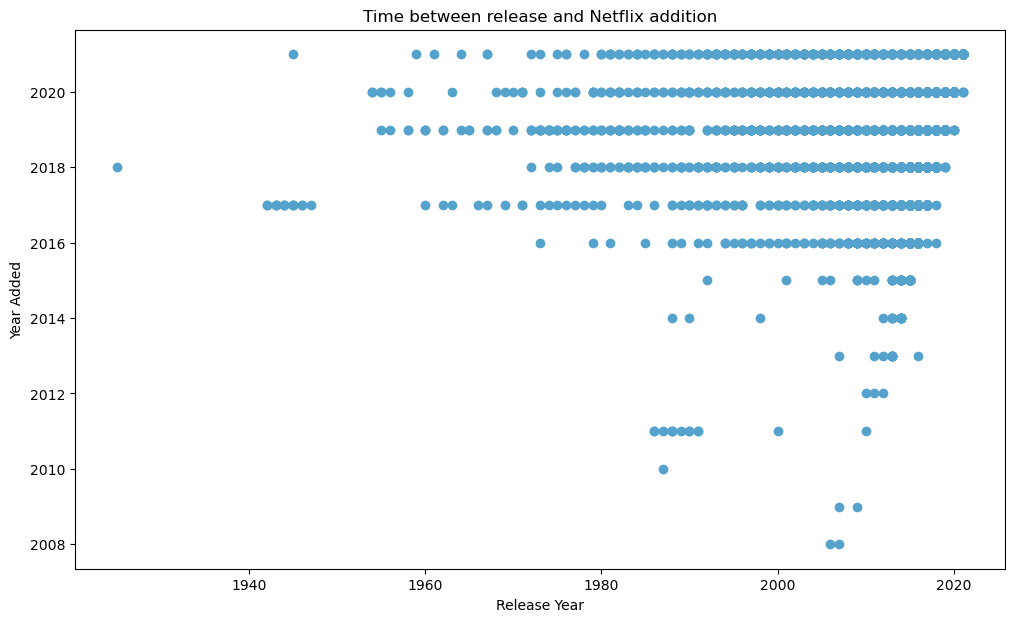

In [14]:
plt.figure(figsize=(12, 7))
plt.scatter(x=df["release_year"], y=df["year_added"])
plt.title("Time between release and Netflix addition")
plt.xlabel("Release Year")
plt.ylabel("Year Added")


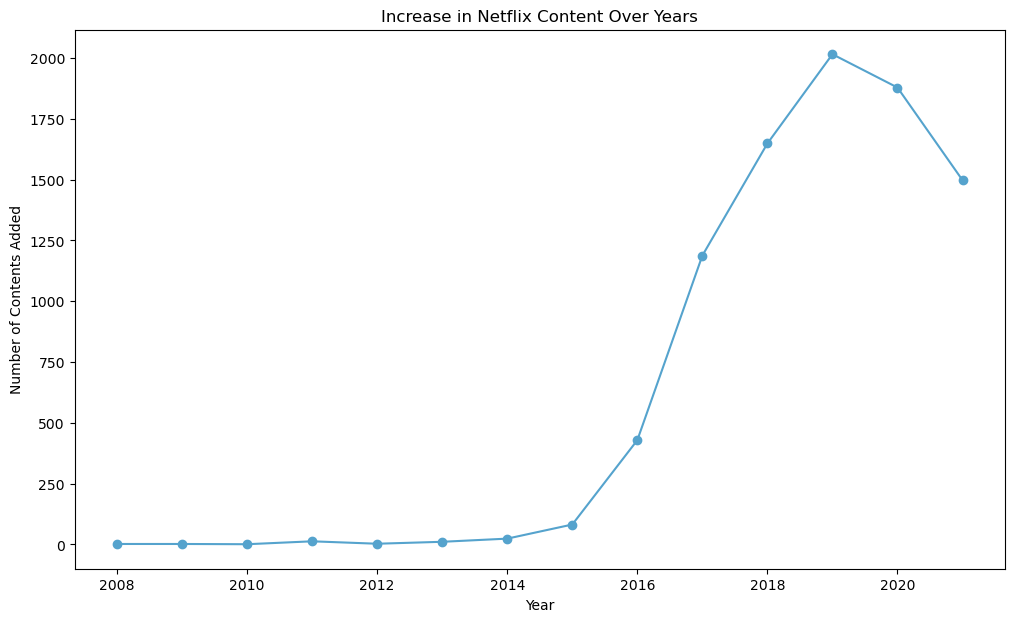

In [15]:
plt.figure(figsize=(12, 7))

df_1 = df.groupby("year_added")["show_id"].count()
df_1.plot(marker='o')
plt.title("Increase in Netflix Content Over Years")
plt.xlabel("Year", color="black")
plt.ylabel("Number of Contents Added")
plt.show()


In [16]:
Totalkidscount = 0
for i in df["listed_in"]:
    if 'kids' in i or 'Children' in i:
        Totalkidscount += 1
Totalkidscount

641

Text(0.5, 1.0, 'Kid Friendly Content')

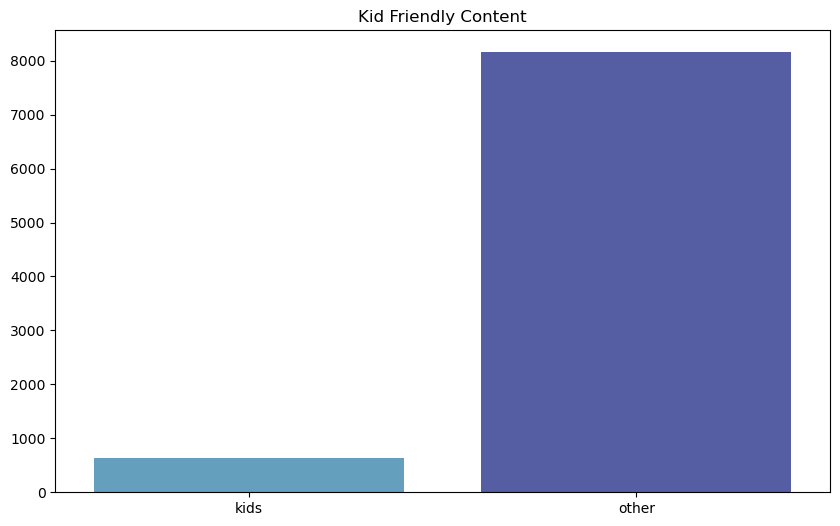

In [17]:
dic = {
    'kids': Totalkidscount,
    'other': df.shape[0] - Totalkidscount
}

sns.barplot(x=list(dic.keys()), y = list(dic.values()))
plt.title('Kid Friendly Content')


In [18]:
Totalkidscount*100/df.shape[0]

7.286574968739343

Text(0.5, 1.0, 'Countries with Most Movies')

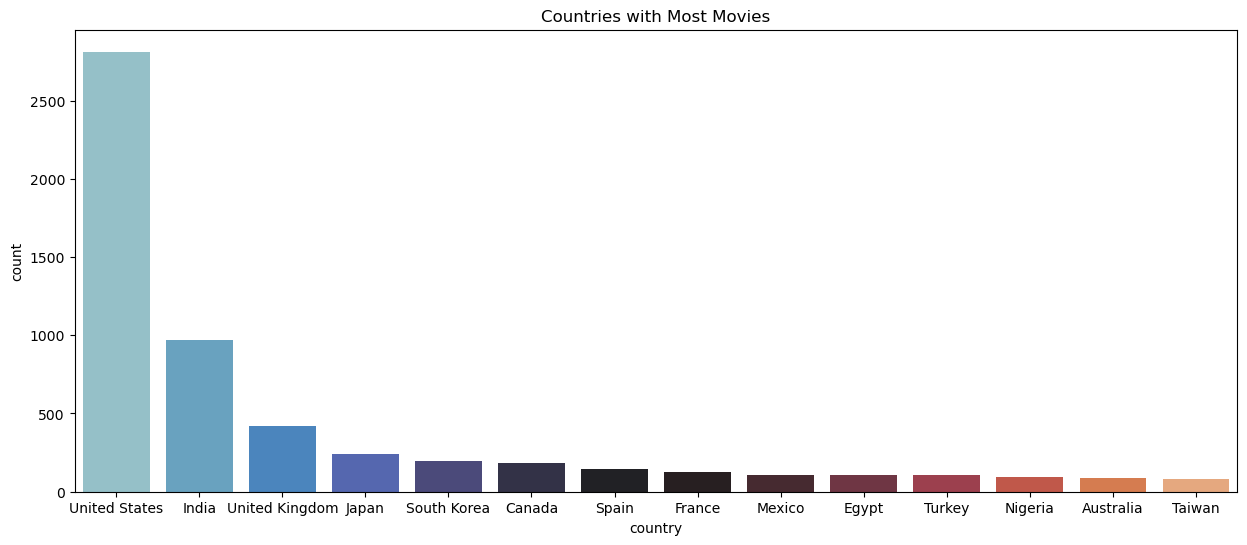

In [19]:
plt.figure(figsize=(15, 6))
sns.countplot(x='country', data=df, order=df['country'].value_counts().index[:14], palette="icefire")
plt.title('Countries with Most Movies')


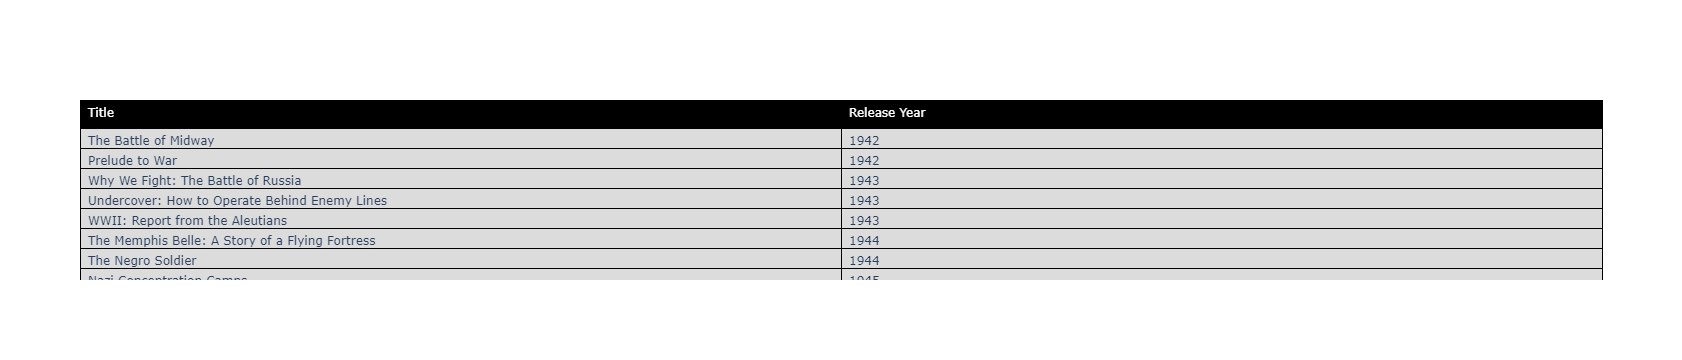

In [20]:
# Filter data for US and sort by release year
oldest_us_series = df[df['country'] == 'United States'].sort_values(by='release_year').head(20)

# Define colors
header_fill_color = 'black'
cell_fill_color = 'gainsboro'
line_color = 'black'
font_color = 'white'

# Create Plotly figure
fig = go.Figure(data=[go.Table(
    header=dict(values=['Title', 'Release Year'], fill_color=header_fill_color, align='left', line_color=line_color, font=dict(color=font_color)),
    cells=dict(values=[oldest_us_series['title'], oldest_us_series['release_year']], fill_color=cell_fill_color, align='left', line_color=line_color))
])

# Show the figure
fig.show()


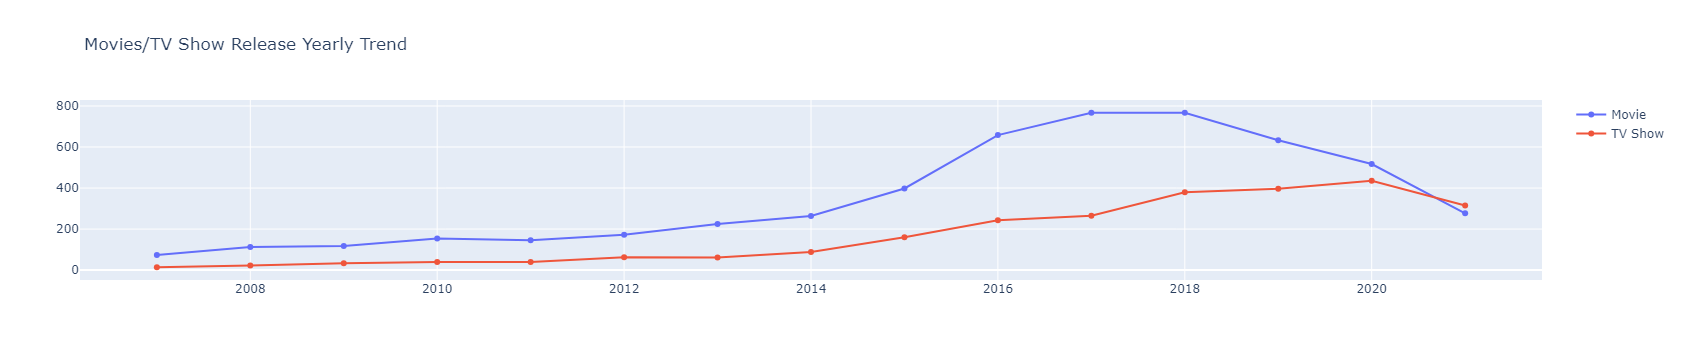

In [21]:
# Filter and group data
netflixfilter = df.query("release_year >= 2007").groupby(["type", "release_year"])["show_id"].count().reset_index()

# Create traces without specifying colors
traces = [
    go.Scatter(
        x=data['release_year'],
        y=data['show_id'],
        mode='lines+markers',
        name=show_type,
        text=data['show_id']
    )
    for show_type, _ in netflixfilter.groupby("type")
    for _, data in netflixfilter[netflixfilter["type"] == show_type].groupby("type")
]

# Create Plotly figure
fig = go.Figure(data=traces)

# Update layout
fig.update_layout(title_text='Movies/TV Show Release Yearly Trend')

# Show the figure
fig.show()


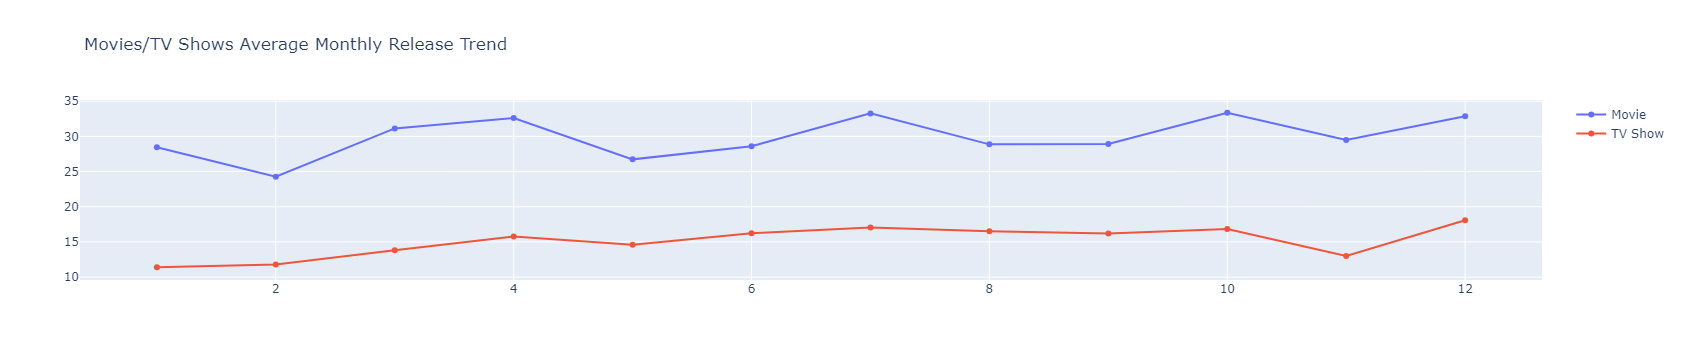

In [22]:

# Filter, group, and aggregate data
netflixfilter = (
    df.query("release_year >= 2007")
    .groupby(['release_year', 'month_added', 'type'])
    .size()
    .reset_index(name='total_shows')
    .groupby(['month_added', 'type'])
    .agg({'total_shows': 'mean'})
    .reset_index()
)

# Create traces without specifying colors
traces = [
    go.Scatter(
        x=data['month_added'],
        y=data['total_shows'],
        mode='lines+markers',
        name=show_type,
        text=data['total_shows']
    )
    for show_type, _ in netflixfilter.groupby("type")
    for _, data in netflixfilter[netflixfilter["type"] == show_type].groupby("type")
]

# Create Plotly figure
fig = go.Figure(data=traces)

# Update layout
fig.update_layout(title_text='Movies/TV Shows Average Monthly Release Trend')

# Show the figure
fig.show()


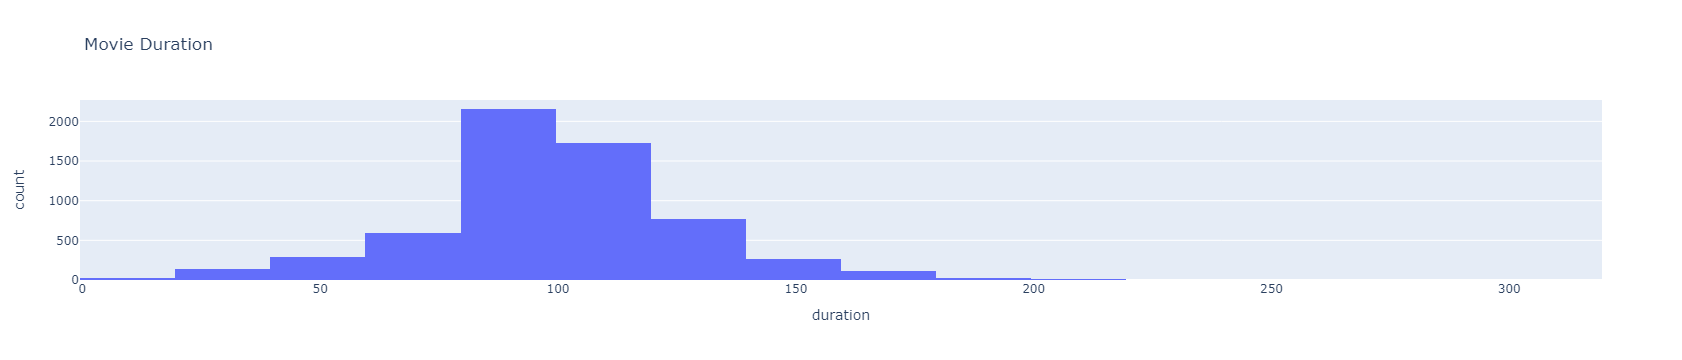

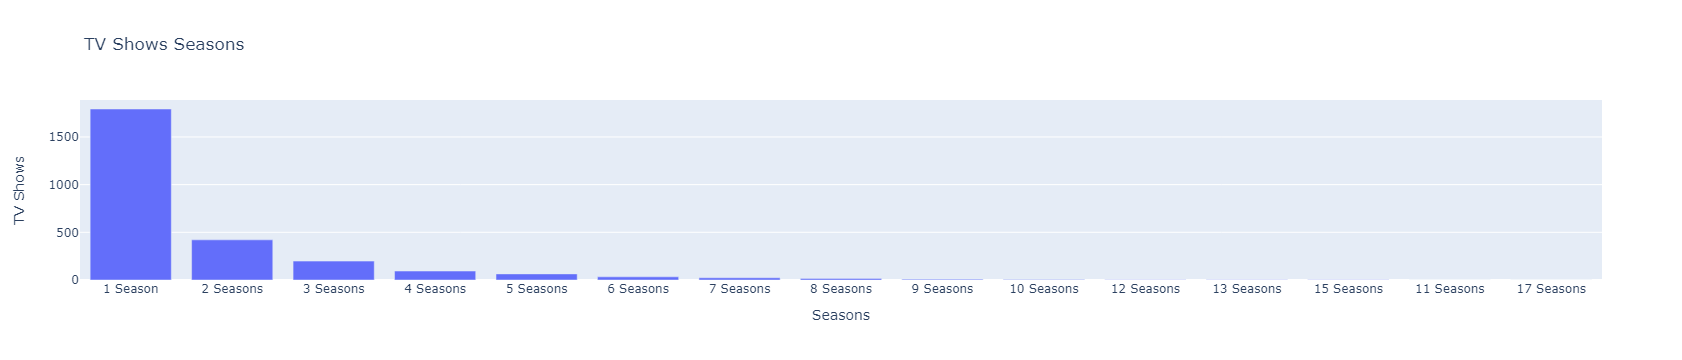

In [23]:
netflixtv = df.query("type == 'TV Show'")[["title", "duration"]]
netflixtv = netflixtv.groupby('duration').size().reset_index(name='TV Shows').sort_values('TV Shows', ascending=False)
netflixtv = netflixtv.rename(columns={"duration": "Seasons"})

netflixmov = df.query("type == 'Movie'")
netflixmov['duration'] = netflixmov['duration'].fillna("0").str.split(" ").str[0].astype(int)

fig_show = px.bar(netflixtv, x='Seasons', y='TV Shows', title='TV Shows Seasons')
fig_Movie = px.histogram(netflixmov, x="duration", nbins=20, title="Movie Duration")

fig_Movie.show()
fig_show.show()

In [24]:
df['director'].value_counts().head(10)

director
Rajiv Chilaka             19
Raúl Campos, Jan Suter    18
Marcus Raboy              16
Suhas Kadav               16
Jay Karas                 14
Cathy Garcia-Molina       13
Martin Scorsese           12
Youssef Chahine           12
Jay Chapman               12
Steven Spielberg          11
Name: count, dtype: int64

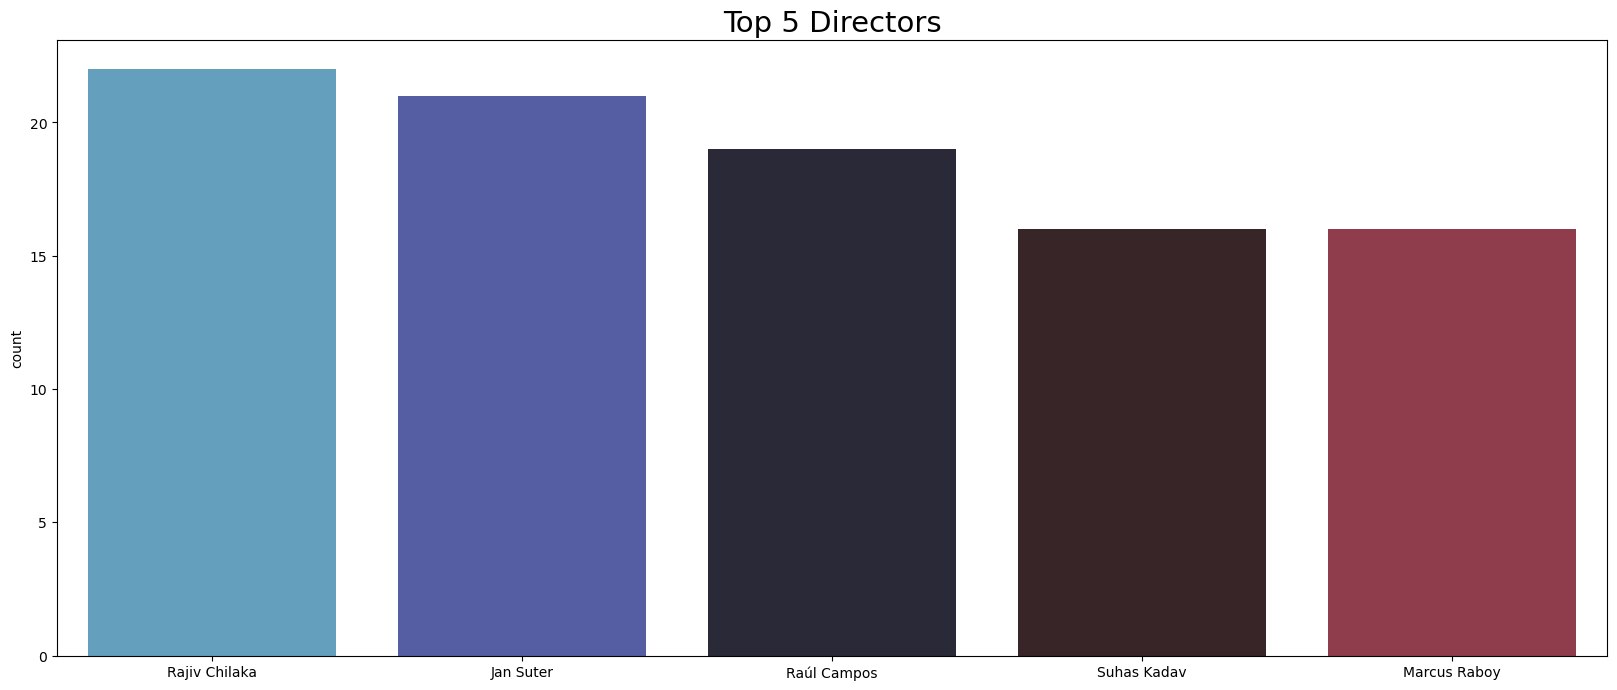

In [25]:
plt.figure(figsize=(20,8))
netflix_directors = df[df.director != 'director unavailable'].set_index('title').director.str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
sns.countplot(x = netflix_directors, order=netflix_directors.value_counts().index[:5])
plt.title('Top 5 Directors', fontsize=21)
plt.show()

In [26]:

listofcg = []
for i in df["listed_in"].dropna():
    x = i.split(",")
    for j in x:
        listofcg.append(j.strip())
        
listofcg = pd.DataFrame(listofcg)
Top10C = listofcg.value_counts()[:10]

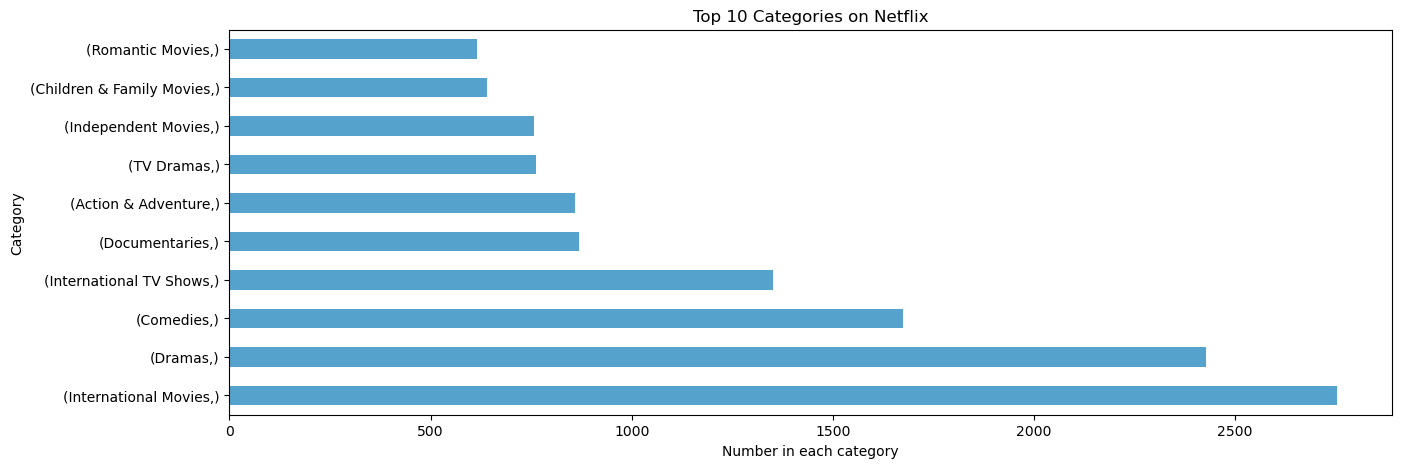

In [27]:
plt.figure(figsize=(15, 5))
Top10C.plot(kind="barh")
plt.xlabel("Number in each category")
plt.ylabel("Category")
plt.title("Top 10 Categories on Netflix")
plt.show()

In [28]:
#TimeSeries Analysis Take 1

In [29]:
df["date_added"]=pd.to_datetime(df['date_added'])
shows_added=df.groupby(pd.Grouper(key='date_added', axis=0, freq='M'))["show_id"].count()
shows_added=shows_added.to_frame()
shows_added = shows_added.rename({"show_id": "value"} , axis = 1)
shows_added

value
date_added       
2008-01-31      1
2008-02-29      1
2008-03-31      0
2008-04-30      0
2008-05-31      0
...           ...
2021-05-31    132
2021-06-30    207
2021-07-31    257
2021-08-31    178
2021-09-30    183

[165 rows x 1 columns]

In [30]:
shows_added.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 165 entries, 2008-01-31 to 2021-09-30
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   165 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


In [31]:
shows_added.isnull().any()

value    False
dtype: bool

In [32]:
start_date = '2014-1-1'
mask = (shows_added.index > start_date)
shows_added=shows_added.loc[mask]
shows_added

value
date_added       
2014-01-31      2
2014-02-28      2
2014-03-31      0
2014-04-30      2
2014-05-31      0
...           ...
2021-05-31    132
2021-06-30    207
2021-07-31    257
2021-08-31    178
2021-09-30    183

[93 rows x 1 columns]

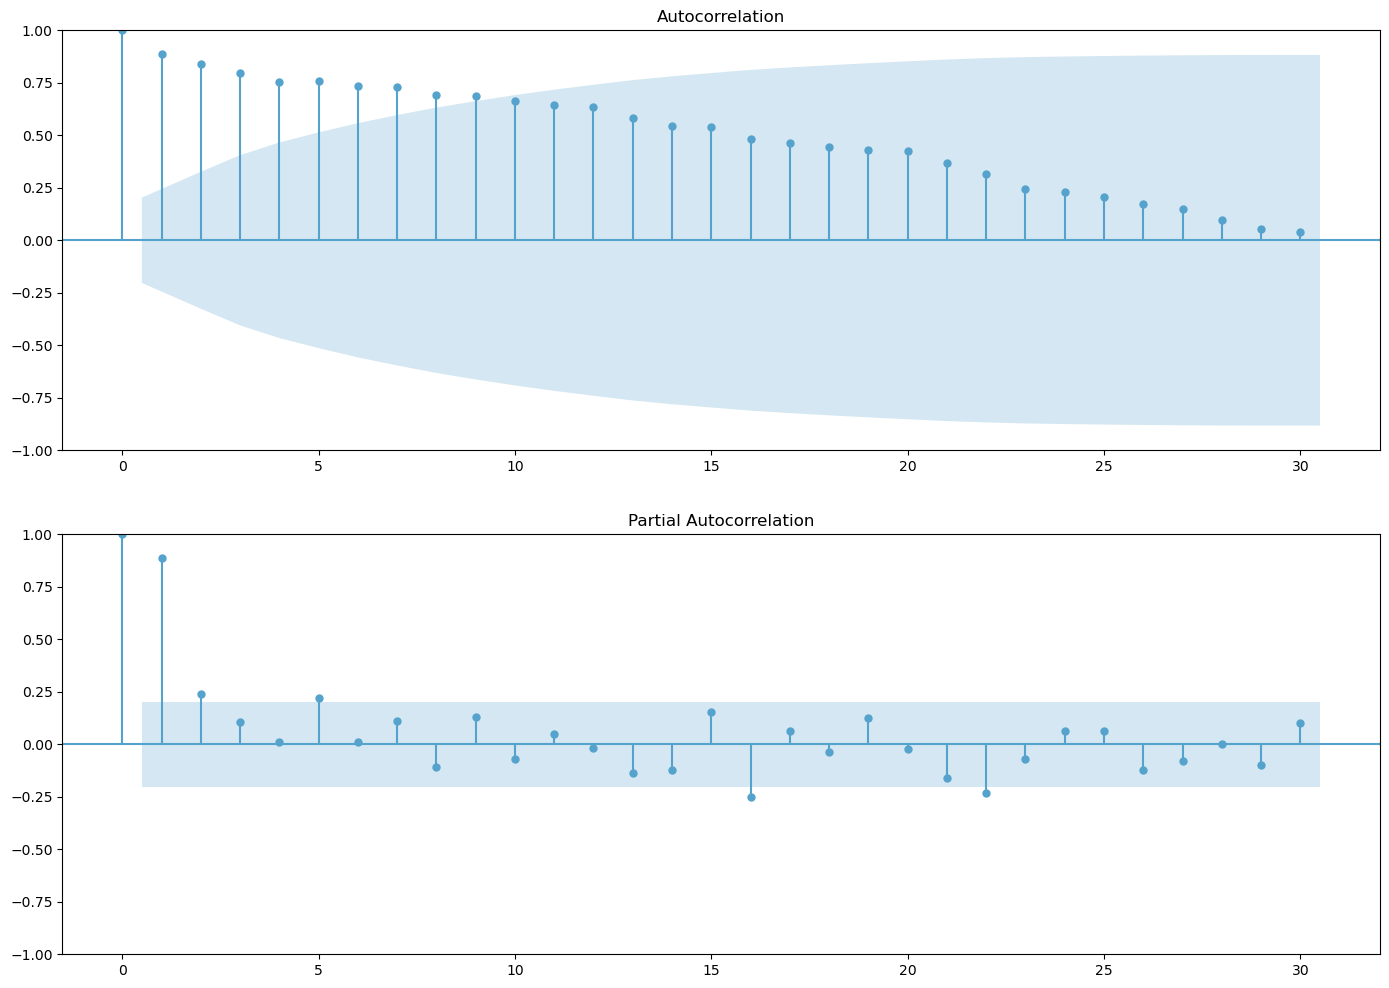

In [33]:
def ACF_and_PACF(data):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 12))
    plot_acf(data, lags=30, ax=ax1)
    plot_pacf(data, lags=30, ax=ax2)
   # plt.tight_layout() 
    #plt.show()

ACF_and_PACF(shows_added['value'])


In [34]:
from statsmodels.tsa.stattools import acf, pacf
def ACF_and_PACF_values(data):
    acf_values = acf(data, nlags=30)
    pacf_values = pacf(data, nlags=30)
    return acf_values, pacf_values

acf_values, pacf_values = ACF_and_PACF_values(shows_added['value'])

print("Autocorrelation Values:")
print(acf_values)

print("\nPartial Autocorrelation Values:")
print(pacf_values)


Autocorrelation Values:
[1.         0.88667945 0.83714537 0.79797041 0.75401716 0.7565203
 0.73289871 0.72965457 0.69335386 0.68684813 0.66223455 0.64317725
 0.63470159 0.58308058 0.54461936 0.53734363 0.48163651 0.46203818
 0.44310114 0.42822411 0.42426637 0.36989983 0.31505007 0.24645046
 0.22926541 0.20577262 0.17339044 0.14820692 0.09859322 0.05256673
 0.03920036]

Partial Autocorrelation Values:
[ 1.          0.89631727  0.26528712  0.12792282  0.01851155  0.25917286
  0.03230337  0.14716779 -0.11669342  0.17182865 -0.07629167  0.07799017
 -0.02450379 -0.16335865 -0.1861196   0.20185635 -0.3850741   0.10988178
 -0.14313547  0.2638155  -0.16521212 -0.15191008 -0.53780311  0.01924747
 -0.18917169  0.3736234  -0.90441886  3.68609212  1.58460627 -0.80643314
  0.23230322]


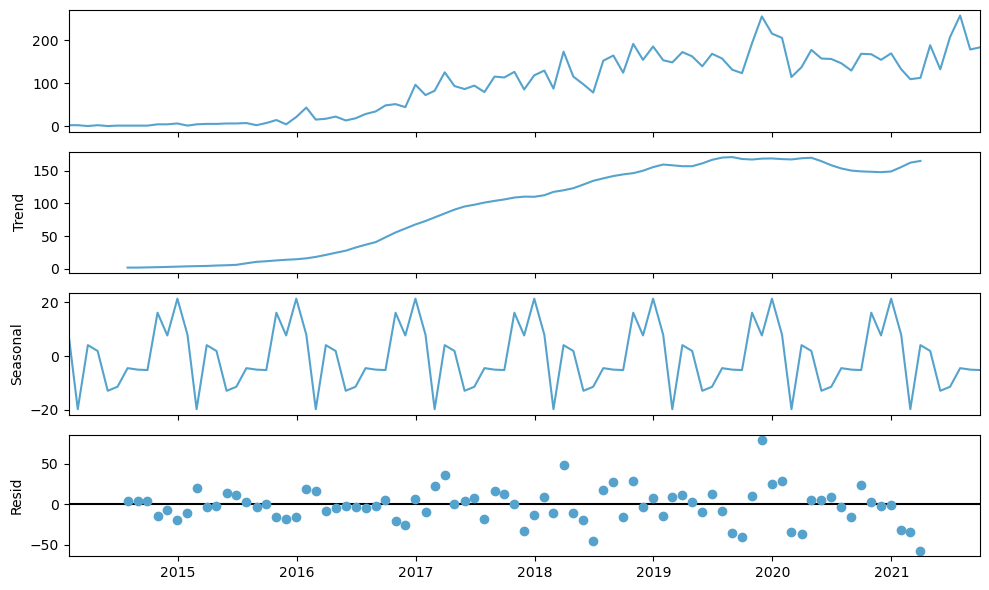

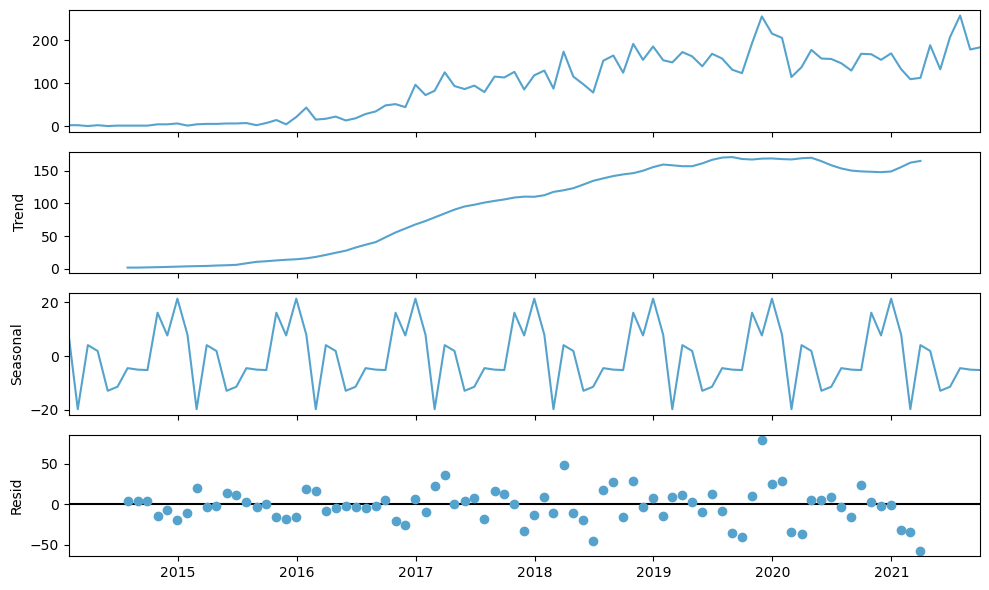

In [35]:
decomposition = sm.tsa.seasonal_decompose(shows_added ,  model = "additive")
decomposition.plot()

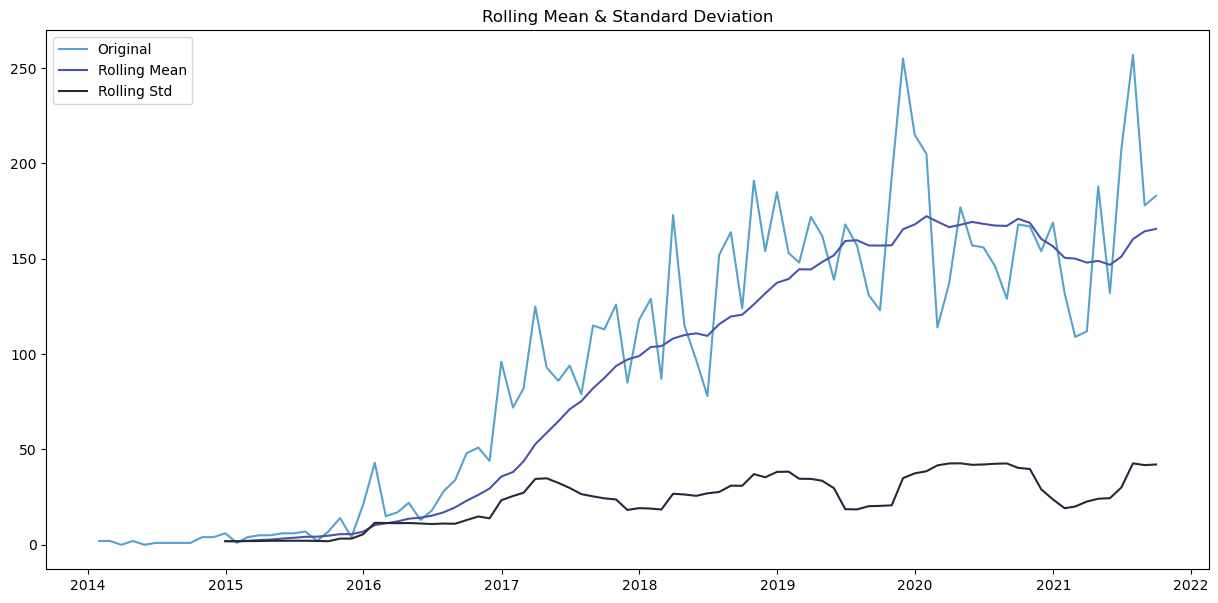

In [36]:
plt.figure(figsize=(15, 7))

rolmean = shows_added.rolling(window=12).mean()
rolstd = shows_added.rolling(window=12).std()

# Plot rolling statistics 
orig = plt.plot(shows_added, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


ADF Test: Test statistic = -0.7685, p-value = 0.82820303
Critical values: {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
Failure to reject null hypothesis, the time series is non-stationary


<Axes: xlabel='date_added'>

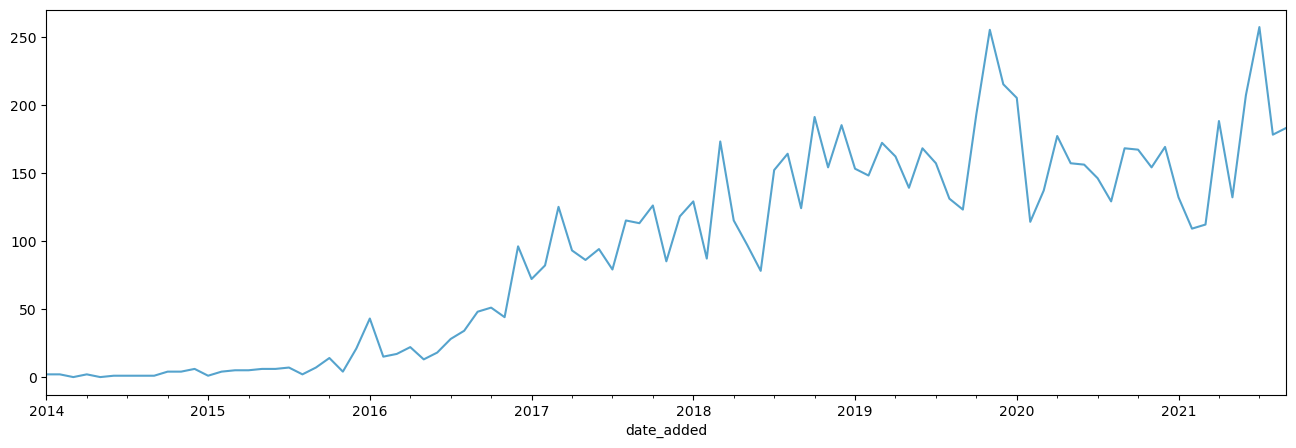

In [37]:
# Compute first difference and drop NaN values
df_diff = shows_added

# Perform Augmented Dickey-Fuller test
adfuller_results = adfuller(df_diff['value'])

# Print test results
print(f"ADF Test: Test statistic = {round(adfuller_results[0], 4)}, p-value = {round(adfuller_results[1], 8)}")
print('Critical values:', adfuller_results[4])

if adfuller_results[1]<=0.05:
    print("Reject null hypothesis, the time series is stationary")
else:
    print("Failure to reject null hypothesis, the time series is non-stationary")

# Plot revenue difference
df_diff['value'].plot(figsize = [16,5])

In [38]:
#Checking

In [39]:
print("Results of Dickey Fuller Test: ")
dftest = adfuller(shows_added['value'] , autolag= "AIC")

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test: 
Test Statistic                 -0.768490
p-value                         0.828203
#Lags Used                      8.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


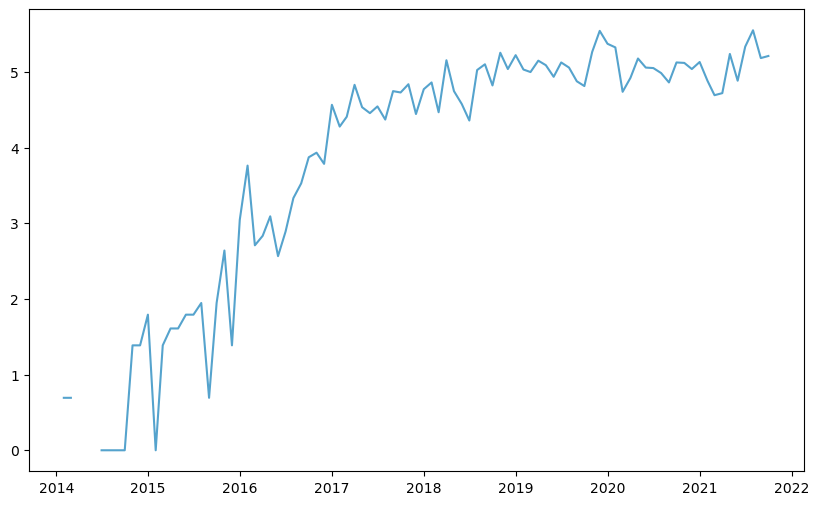

In [40]:
df_logScale = np.log(shows_added)
plt.plot(df_logScale)

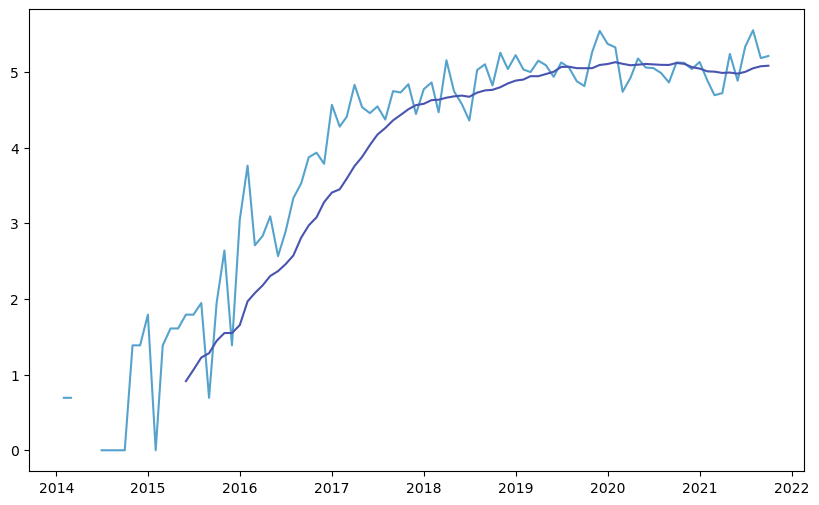

In [41]:
#make series stationary
movingAverage = df_logScale.rolling(window=12).mean()
movingSTD = df_logScale.rolling(window=12).std()
plt.plot(df_logScale)
plt.plot(movingAverage)

In [42]:
data_SMMA = df_logScale - movingAverage
data_SMMA.head(12)
data_SMMA.dropna(inplace=True)


In [43]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, label='Original')
    mean = plt.plot(movingAverage,  label='Rolling Mean')
    std = plt.plot(movingSTD, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['value'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

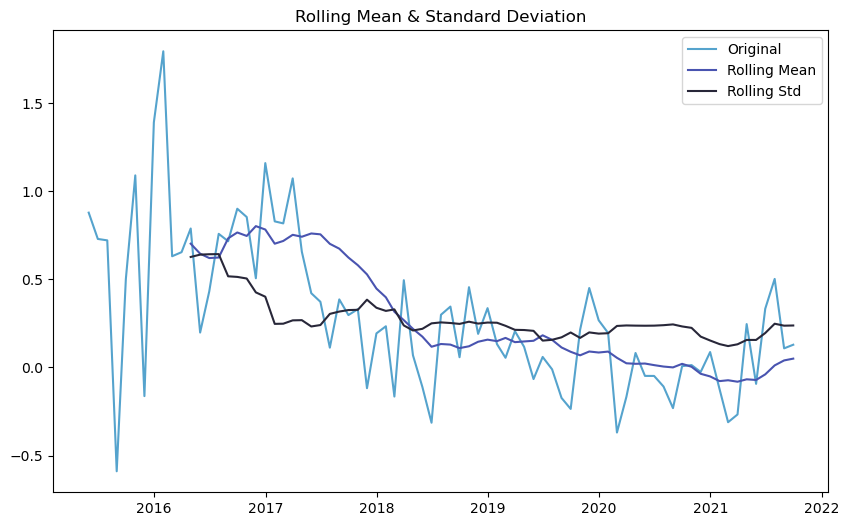

Results of Dickey Fuller Test:
Test Statistic                 -2.303355
p-value                         0.170888
#Lags Used                      2.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [44]:
test_stationarity(data_SMMA)

In [45]:
#Model

In [46]:
data = data_SMMA.dropna()
data

value
date_added          
2015-05-31  0.878320
2015-06-30  0.729006
2015-07-31  0.720998
2015-08-31 -0.589527
2015-09-30  0.501076
...              ...
2021-05-31 -0.093363
2021-06-30  0.332982
2021-07-31  0.502217
2021-08-31  0.108094
2021-09-30  0.128669

[77 rows x 1 columns]

In [47]:
train = data[:4988]
test = data[4988:]

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   77
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -35.300
Date:                Wed, 21 Feb 2024   AIC                             76.600
Time:                        14:08:21   BIC                             83.631
Sample:                    05-31-2015   HQIC                            79.412
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5000      0.060      8.347      0.000       0.383       0.617
ar.L2          0.2449      0.069      3.572      0.000       0.111       0.379
sigma2         0.1451      0.017      8.732      0.0

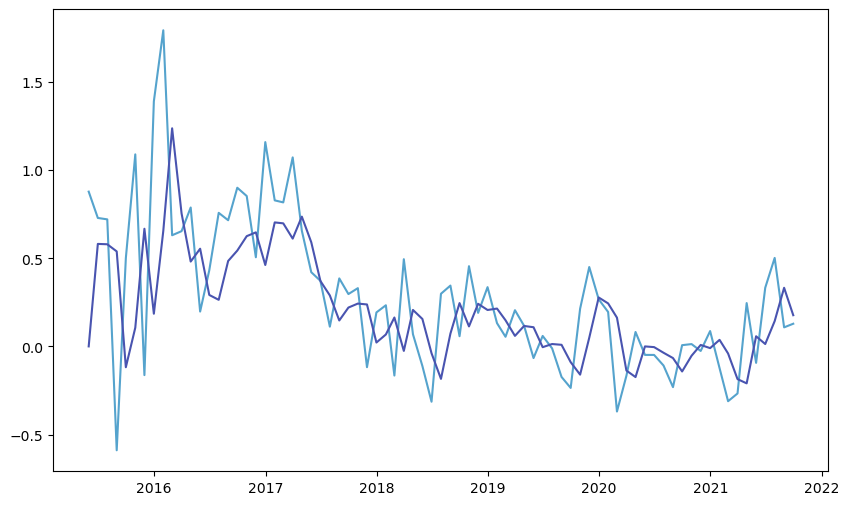

In [48]:
modelr = SARIMAX(train , order= (2,0,0))
tol = modelr.fit()
plt.plot(train)
plt.plot(tol.fittedvalues)
print(tol.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   77
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 -41.707
Date:                Wed, 21 Feb 2024   AIC                             89.414
Time:                        14:08:22   BIC                             96.446
Sample:                    05-31-2015   HQIC                            92.227
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7549      0.109      6.897      0.000       0.540       0.969
ma.L2          0.0152      0.106      0.142      0.887      -0.193       0.224
sigma2         0.1712      0.023      7.435      0.0

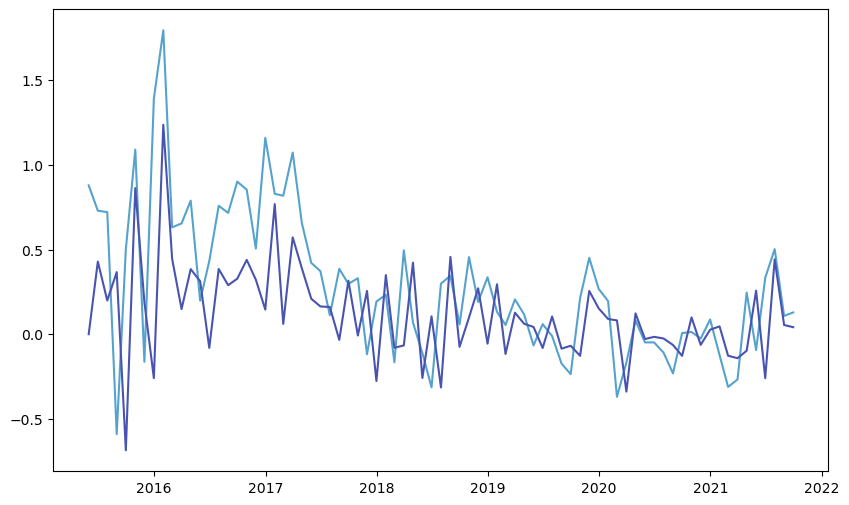

In [49]:
model2 = SARIMAX(train , order= (0,0,2))
dol = model2.fit()
plt.plot(train)
plt.plot(dol.fittedvalues)
print(dol.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   77
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -24.178
Date:                Wed, 21 Feb 2024   AIC                             58.357
Time:                        14:08:22   BIC                             70.076
Sample:                    05-31-2015   HQIC                            63.044
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3872      0.111      3.475      0.001       0.169       0.606
ar.L2          0.5908      0.100      5.884      0.000       0.394       0.788
ma.L1          0.1008      0.157      0.643      0.5

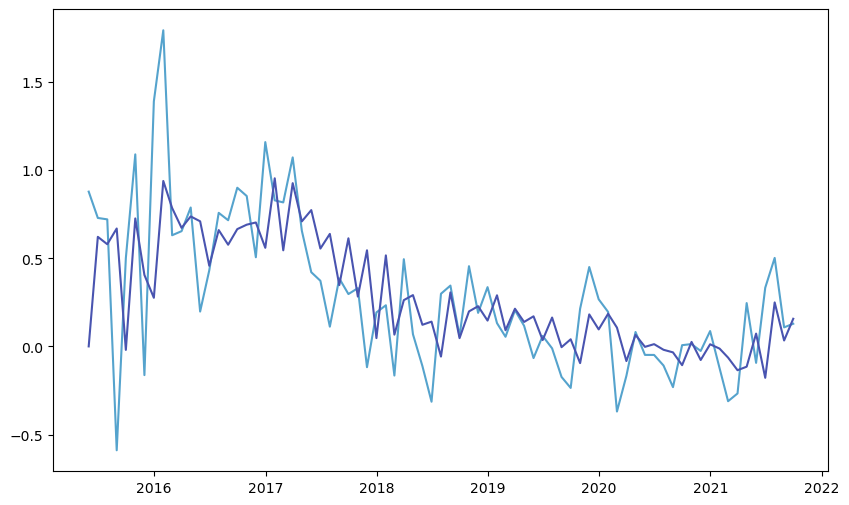

In [50]:
model3 = SARIMAX(train , order= (2,0,2))
col = model3.fit()
plt.plot(train)
plt.plot(col.fittedvalues)
print(col.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   77
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -23.256
Date:                Wed, 21 Feb 2024   AIC                             56.513
Time:                        14:08:23   BIC                             68.166
Sample:                    05-31-2015   HQIC                            61.170
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6639      0.121     -5.468      0.000      -0.902      -0.426
ar.L2         -0.1610      0.169     -0.952      0.341      -0.492       0.170
ma.L1          0.1085      0.175      0.620      0.5

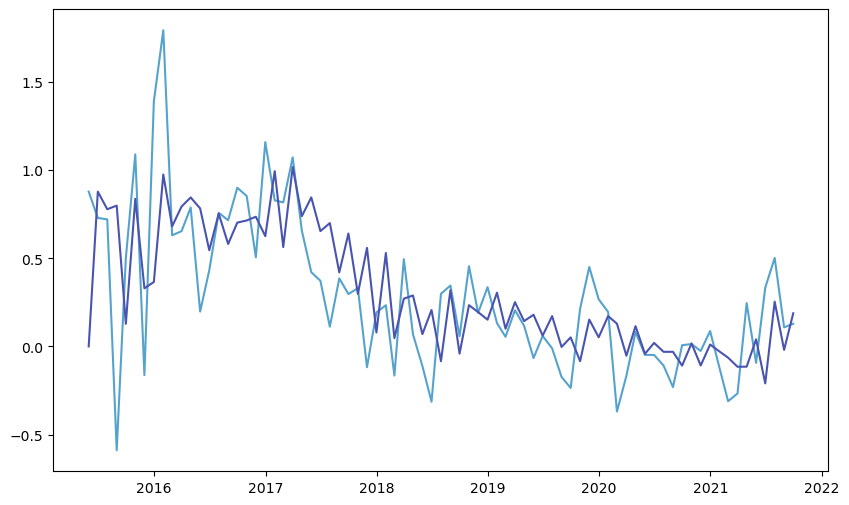

In [51]:
model4 = SARIMAX(train , order= (2,1,2))
pol = model4.fit()
plt.plot(train)
plt.plot(pol.fittedvalues)
print(pol.summary())

In [52]:
# Create Training and Test
train = shows_added[:63]
test = shows_added[63:]

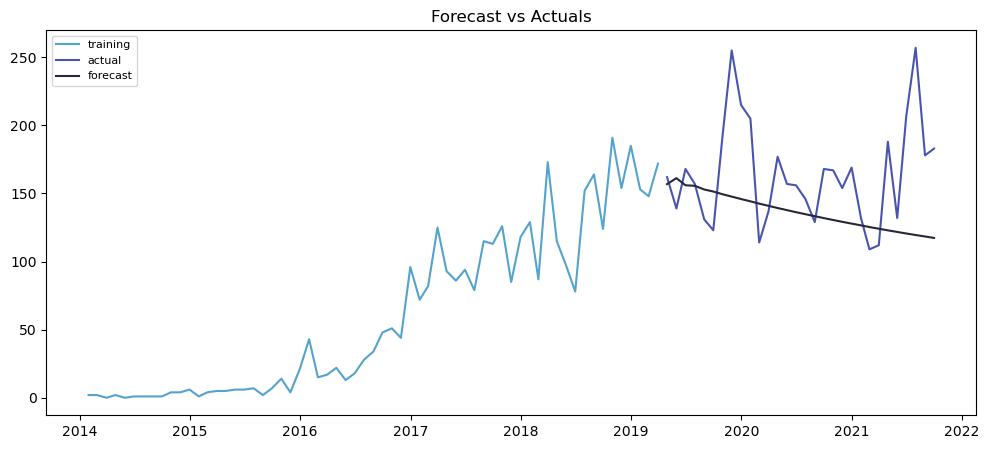

In [53]:
# Build Model
model = sm.tsa.arima.ARIMA(train, order=(2,0,0))  
fitted = model.fit()  

# Forecast
fc= fitted.forecast(steps=30, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [54]:
def forecast_accuracy(forecast, actual):
    forecast = forecast.squeeze()  
    actual = actual.squeeze()     
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) 
    me = np.mean(forecast - actual)            
    mae = np.mean(np.abs(forecast - actual))   
    mpe = np.mean((forecast - actual)/actual) 
    rmse = np.mean((forecast - actual)**2)**.5  
    corr = np.corrcoef(forecast, actual)[0, 1]  
    mins = np.amin(np.vstack([forecast, actual]), axis=0)
    maxs = np.amax(np.vstack([forecast, actual]), axis=0)
    minmax = 1 - np.mean(mins/maxs)             

    acf1 = acf(forecast - actual)[1]          
    return {'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax}

forecast_accuracy(fc, test)


{'mape': 0.19970231694348803,
 'me': -27.232842180121768,
 'mae': 36.43382671187031,
 'mpe': -0.12433409244963155,
 'rmse': 48.616288887525435,
 'acf1': 0.4491040148429595,
 'corr': -0.07615978582871992,
 'minmax': 0.1939721697303377}

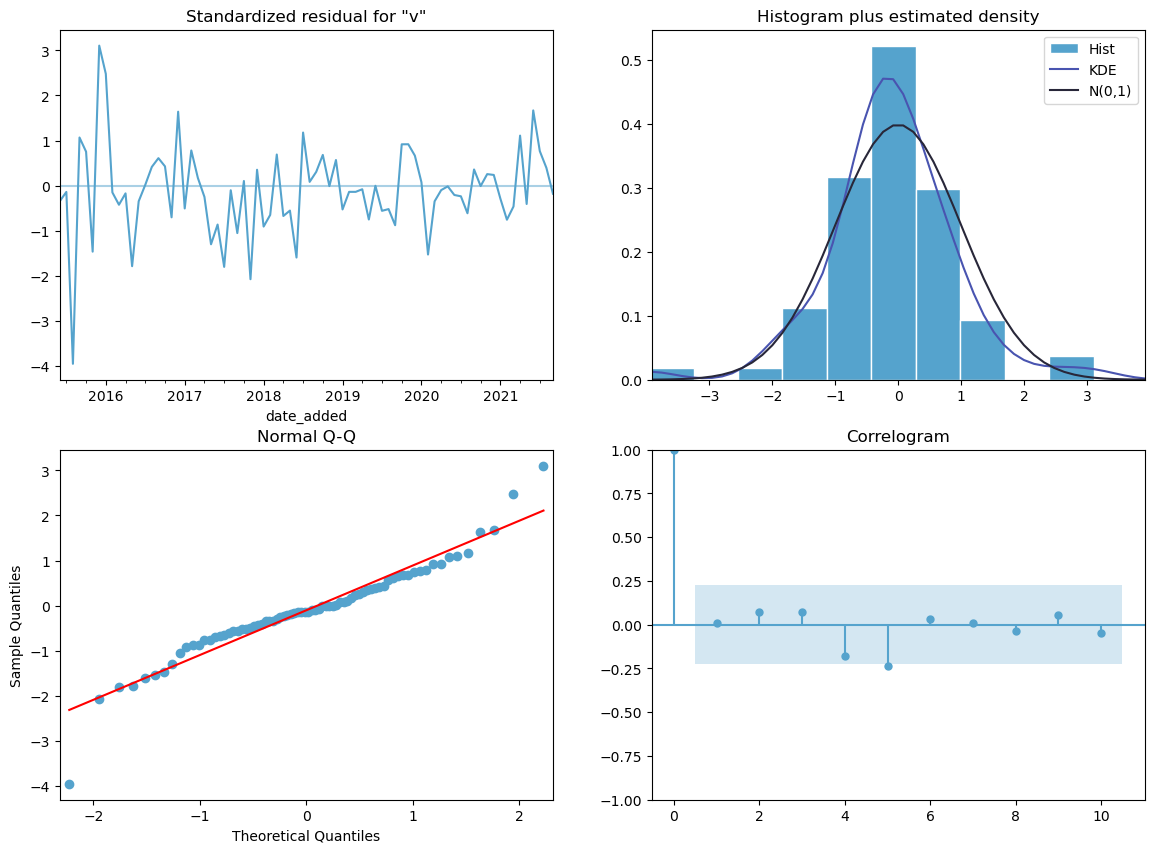

In [58]:
pol.plot_diagnostics(figsize=(14,10))
plt.show()